In [1]:
pip install pyspark

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Number of clusters: 592


24/05/12 02:26:52 WARN CacheManager: Asked to cache already cached data.
24/05/12 02:26:52 WARN CacheManager: Asked to cache already cached data.


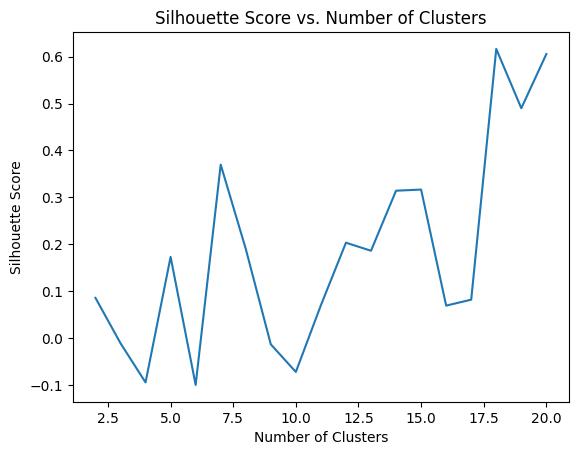

Silhouette Score: 0.6164301795474283
Recommended Tracks for Track ID 139:
+--------+
|track_id|
+--------+
|     139|
|     535|
|    1195|
|    1326|
|    1699|
|    3266|
|    3883|
|    4450|
|    5054|
|    6460|
|    6795|
|    7021|
|   10532|
|   11458|
|   11643|
|   12753|
|   12808|
|   12852|
|   13878|
|   15265|
+--------+
only showing top 20 rows

Recommended Tracks for Track ID 152:
+--------+
|track_id|
+--------+
|     152|
|     317|
|     338|
|     367|
|     504|
|     569|
|     796|
|     844|
|     991|
|    1148|
|    1159|
|    1282|
|    1284|
|    1522|
|    1752|
|    1804|
|    1961|
|    1993|
|    3478|
|    3651|
+--------+
only showing top 20 rows

Recommended Tracks for Track ID 165:
+--------+
|track_id|
+--------+
|     165|
|     166|
|     274|
|     421|
|     424|
|     438|
|     999|
|    1003|
|    1511|
|    2001|
|    2020|
|    4006|
|    4056|
|    7210|
|    7347|
|    7472|
|    8204|
|    8211|
|    8268|
|    9244|
+--------+
only sho

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.sql.types import DoubleType
from sklearn.metrics import adjusted_rand_score
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder \
    .appName("MusicRecommendationSystem") \
    .getOrCreate()

# Load the dataset
df = spark.read.csv("merged_data.csv", header=True, inferSchema=True)

# Convert 'duration' column to numeric
df = df.withColumn("duration", df["duration"].cast(DoubleType()))

# Convert 'genre_top_Blues' column to numeric
df = df.withColumn("genre_top_Blues", col("genre_top_Blues").cast(DoubleType()))

# Filter out rows with null values in selected features
selected_features = ['duration', 'listens', 'interest', 'genre_top_Blues', 'genre_top_Classical', 'genre_top_Country', 'genre_top_Easy Listening', 'genre_top_Electronic', 'genre_top_Experimental', 'genre_top_Folk', 'genre_top_Hip-Hop', 'genre_top_Instrumental', 'genre_top_International', 'genre_top_Jazz', 'genre_top_Old-Time / Historic', 'genre_top_Pop', 'genre_top_Rock', 'genre_top_Soul-RnB', 'genre_top_Spoken']
df_filtered = df.na.drop(subset=selected_features)

# Count the number of distinct clusters
num_clusters = df_filtered.select('track_id').distinct().count()
print("Number of clusters:", num_clusters)

# Check if the number of clusters is greater than one
if num_clusters > 1:
    # Initialize an empty dictionary to store silhouette scores
    silhouette_scores = {}

    # Range of cluster numbers to test
    num_clusters_range = range(2, 21)

    # Create a VectorAssembler to assemble features into a vector
    assembler = VectorAssembler(inputCols=selected_features, outputCol="features")

    # Create a StandardScaler to normalize the features
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)

    # Define the evaluator
    evaluator = ClusteringEvaluator()

    for k in num_clusters_range:
        # Define the K-means clustering model
        kmeans = KMeans(featuresCol="scaledFeatures", k=k, seed=42)

        # Create a pipeline to chain feature transformation, scaling, and K-means model
        pipeline = Pipeline(stages=[assembler, scaler, kmeans])

        # Define a parameter grid for hyperparameter tuning
        param_grid = ParamGridBuilder().build()

        # Create a TrainValidationSplit
        train_val_split = TrainValidationSplit(estimator=pipeline,
                                               estimatorParamMaps=param_grid,
                                               evaluator=evaluator,
                                               trainRatio=0.8)  # 80% of the data will be used for training

        # Fit the TrainValidationSplit to the data
        tv_model = train_val_split.fit(df_filtered)

        # Get the best model from the TrainValidationSplit
        best_model = tv_model.bestModel

        # Apply the best model to the data to get cluster assignments
        predictions = best_model.transform(df_filtered)

        # Evaluate clustering by computing Silhouette score
        silhouette_score = evaluator.evaluate(predictions)

        # Store silhouette score for this cluster number
        silhouette_scores[k] = silhouette_score

    # Plotting the silhouette scores
    import matplotlib.pyplot as plt

    plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score vs. Number of Clusters")
    plt.show()

    # Proceed with the original code after determining the optimal number of clusters

    # Define the K-means clustering model with the best number of clusters
    best_k = max(silhouette_scores, key=silhouette_scores.get)
    kmeans = KMeans(featuresCol="scaledFeatures", k=best_k, seed=42)

    # Create a pipeline to chain feature transformation, scaling, and K-means model
    pipeline = Pipeline(stages=[assembler, scaler, kmeans])

    # Fit the pipeline to the data
    model = pipeline.fit(df_filtered)

    # Make predictions
    predictions = model.transform(df_filtered)

    # Convert the DataFrame to Pandas DataFrame
    true_labels = df_filtered.select('track_id').toPandas()
    predicted_labels = predictions.select('track_id', 'prediction').toPandas()

    # Merge true labels and predicted labels based on track_id
    merged_labels = pd.merge(true_labels, predicted_labels, on='track_id')

    # Evaluate the best model using evaluation metrics
    silhouette_score = evaluator.evaluate(predictions)
    print("Silhouette Score:", silhouette_score)

    # Function to recommend tracks based on input track IDs
    def recommend_tracks(input_track_ids):
        for track_id in input_track_ids:
            # Get the cluster assignment for the input track
            input_track_cluster = predictions.filter(col("track_id") == track_id).select("prediction").first()[0]

            # Filter tracks belonging to the same cluster as the input track
            recommended_tracks = predictions.filter(col("prediction") == input_track_cluster).select("track_id")

            # Show recommended tracks for the input track ID
            print(f"Recommended Tracks for Track ID {track_id}:")
            recommended_tracks.show()

    # Example usage: Recommend tracks similar to the first 10 rows of track IDs
    input_track_ids = df_filtered.select("track_id").limit(10).rdd.flatMap(lambda x: x).collect()
    recommend_tracks(input_track_ids)

else:
    print("Error: Number of clusters must be greater than one.")

# Stop Spark session
spark.stop()









